# Predict response to stimuli: lstm for time series

In a *lstm timeseries* problem, we aim to predict the response of a stimuli, as a time series data. The input is a stimuli vs time and the output is response vs time curve. Depending on how we train the network the response curve could represent average response to the stimuli from different spatial locations or could represet response form a single spatial location. 

This notebook builds an LSTM based model to predict the response to external stimuli. To do this, we'll provide the model with timeseries of stimuli and use the return sequences to return an output vector that has the same shape as that of the input time series, the output represents response to the stimuli.

In [1]:
import keras, tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
from IPython import display
from pathlib import Path
import os

The input csv file contains N columns of response as tabular data, we load the data from disk and read it to a numpy array

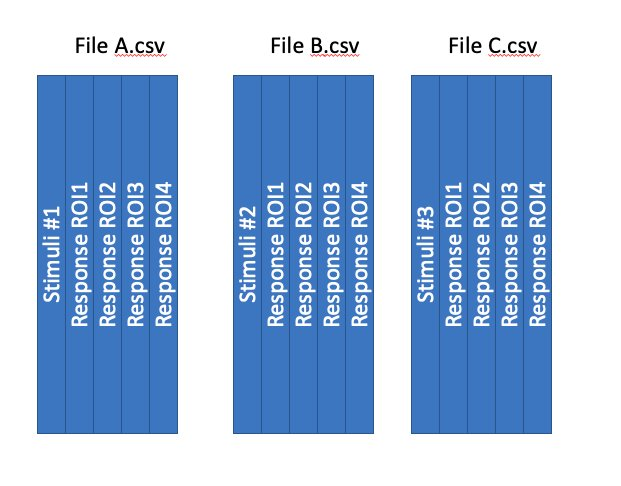

In [2]:
display.Image(filename='../images/data_style.jpg')

Model Name ROI1 Output data shape (9, 2000)
Model Name ROI2 Output data shape (9, 2000)
Model Name ROI3 Output data shape (9, 2000)
Model Name ROI4 Output data shape (9, 2000)
Model Name ROI5 Output data shape (9, 2000)
Model Name ROI6 Output data shape (9, 2000)
Model Name ROI7 Output data shape (9, 2000)
Model Name ROI8 Output data shape (9, 2000)
Model Name ROI9 Output data shape (9, 2000)
Model Name ROI10 Output data shape (9, 2000)
Input data shape (9, 2000, 1)


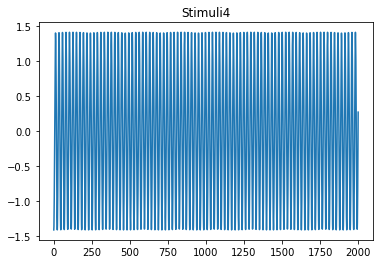

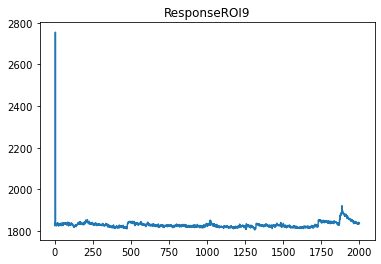

In [3]:
data_dir = Path('C:/Users/rando/Downloads/stimuli_response/')
files = list(data_dir.glob('*.csv'))
stimuli = []
response_roi = []
response = {}
model_name = []
common_name = 'ROI'
for count, file in enumerate(files):
    
  stimuli_data = pd.read_csv(file, header=None)
  
  stimuli_data_tuple = stimuli_data.to_numpy()
  stimuli_data_array = np.asarray(stimuli_data_tuple)
  stimuli.append(stimuli_data_array[:,0])
  for i in range(1, stimuli_data_array.shape[1]):
    if common_name + str(i) in response.keys():
      response_list = response[common_name + str(i)]
      response_list.append(stimuli_data_array[:,i]) 
    else:  
      response[common_name + str(i)] = [stimuli_data_array[:,i]]
  
stimuli = np.asarray(stimuli)
stimuli = (stimuli - stimuli.mean()) / stimuli.std()
#This is our input data for training
stimuli = np.reshape(stimuli, (count + 1, stimuli_data_array.shape[0], 1 ) )
# Now we create a dictionary of the target whose key is the name of the model and value is the training label
for (k,v) in response.items():
    varr = np.asarray(v)
    response[k] = varr
    print('Model Name', k, 'Output data shape', varr.shape)
print('Input data shape', stimuli.shape)    

example_plot = 4
plt.plot(np.arange(stimuli.shape[1]), stimuli[example_plot,:,0])
plt.title('Stimuli'+  str(example_plot))
plt.show()
plt.plot(np.arange(stimuli.shape[1]),response[list(response.keys())[8]][example_plot,:])
plt.title('Response' + str(list(response.keys())[8]))
plt.show()

In [4]:
input_shape = (stimuli.shape[1],stimuli.shape[2])
units = 64
learning_rate = 0.01
epochs = 150
batch_size = 4
validation_split = 0.1

The dataset contains 4 colums of the stimuli and the first number represents the number of timepoints present in the data

In [14]:
from keras import layers, models
from keras.layers import ConvLSTM1D, LSTM, Conv1D, Dense, UpSampling1D, Bidirectional, Conv1D,Dropout,Concatenate, BatchNormalization, MaxPooling1D
inputs = layers.Input(shape = input_shape)
#First Layer
conv1 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' ) (inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal' ) (conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2) (conv1)

#Second Layer

conv2 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)


#Third Layer

conv3 = Conv1D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv1D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D(pool_size=2)(conv3)

#Fourth Layer

conv4 = Conv1D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv1D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)

#Dropout

drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling1D(pool_size=2)(drop4)


#Fifth Layer

conv5 = Conv1D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv1D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)

#Upsampling Layers

up6 = Conv1D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(drop5))
merge6 = Concatenate(axis=-1)([conv4,up6])
conv6 = Conv1D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv1D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv1D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv6))
merge7 = Concatenate(axis=-1)([conv3,up7])
conv7 = Conv1D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv1D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv1D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv7))
merge8 = Concatenate(axis=-1)([conv2,up8])
conv8 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv1D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv1D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv8))
merge9 = Concatenate(axis=-1)([conv1,up9])
conv9 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv1D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv1D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv10 = Conv1D(1, 1, activation = 'sigmoid')(conv9)
outputs = conv10
model = models.Model(inputs, outputs)
opt = keras.optimizers.RMSprop(lr=learning_rate)

model.compile(loss='mse',
              optimizer=opt, metrics = ['mae'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2000, 64)     256         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 2000, 64)    256         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_12 (Conv1D)             (None, 2000, 64)     12352       ['batch_normalization_10[0]

c:\Users\rando\anaconda3\envs\naparienv\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Now let us plot the network graph using keras plot_model

<IPython.core.display.Image object>


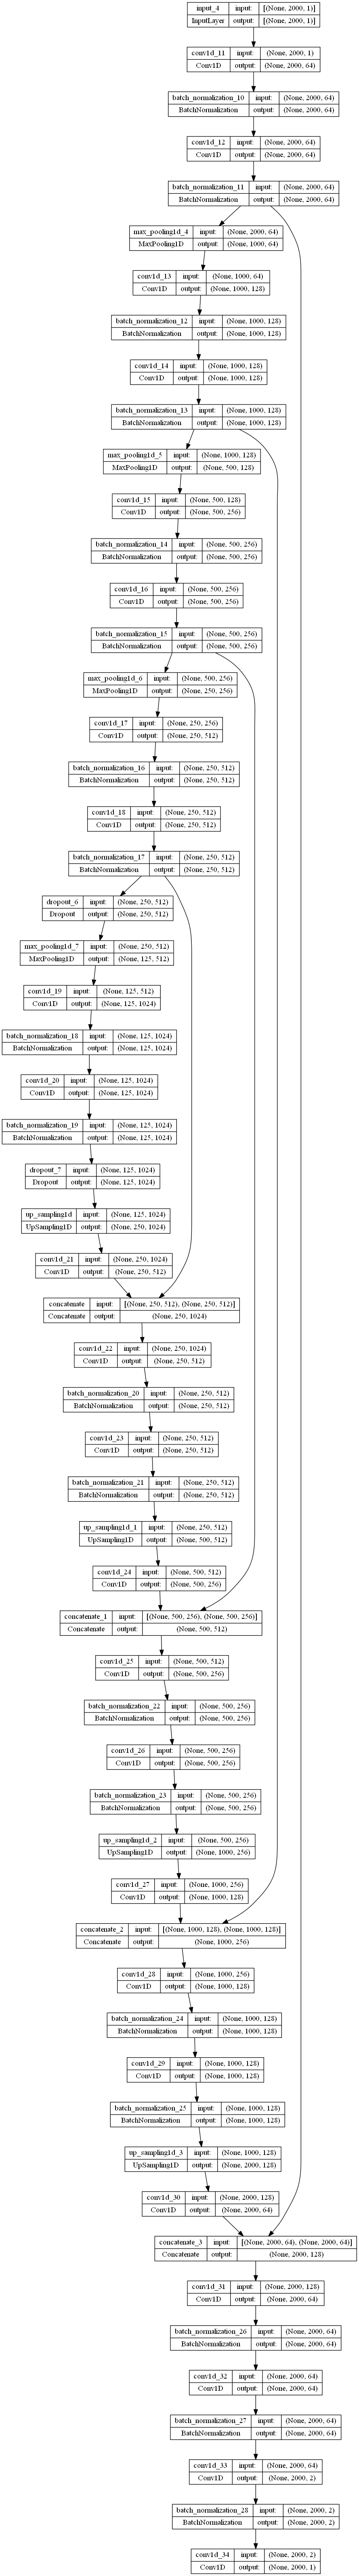

In [15]:
from keras.utils import plot_model

model_inline = plot_model(model, to_file = './model_time_series.png', 
show_shapes = True, show_layer_names=True)

print(model_inline)
model_inline

In [16]:
def plot_history(history):
  plt.figure()
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  
  plt.show()

Now let us start the model training by first defining some parameters like epochs, validation_split, keras callbacks etc

In [17]:
from keras import callbacks
for (k,v) in response.items():
        model_name = k 
        # Keras callbacks
        lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
        srate = callbacks.ModelCheckpoint(data_dir.as_posix() +  '/models/' + model_name + '.h5', monitor='loss', verbose=1,
                                          save_best_only=False, save_weights_only=False, mode='auto', period=1)
        history = model.fit(stimuli, v,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = False,
                    validation_split= validation_split,
                    shuffle=True,
                               callbacks=[lrate, srate])
        plot_history(history) 
        